In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [2]:
dataset = datasets.OxfordIIITPet(root='./data', target_types='segmentation', target_transform=transform, download=True, transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset, [3500, len(dataset)-3500])
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

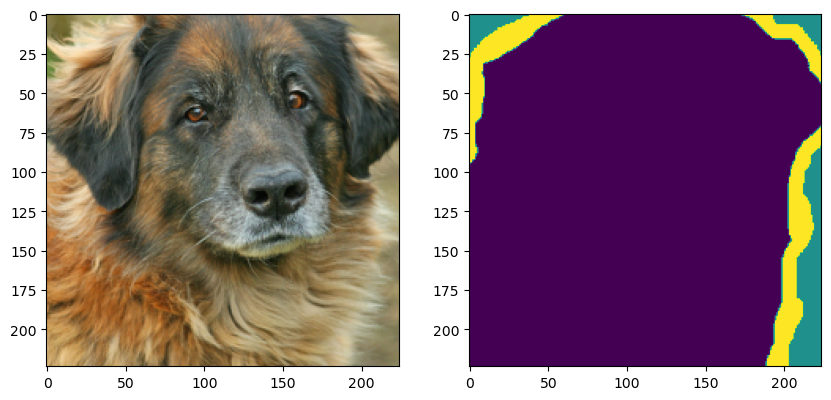

In [3]:
a, b = next(iter(train_loader))

# print(a.shape)
# print(b.shape)

# print(a[0])
# print(b[0])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
data_index = 10
ax[0].imshow(a[data_index].permute(1, 2, 0))
ax[1].imshow(b[data_index, 0])

### Define UNet class

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            cbr = nn.Sequential(*layers)

            return cbr

        self.enc1_1 = CBR(in_channels=3, out_channels=64)
        self.enc1_2 = CBR(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR(in_channels=64, out_channels=128)
        self.enc2_2 = CBR(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR(in_channels=128, out_channels=256)
        self.enc3_2 = CBR(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR(in_channels=256, out_channels=512)
        self.enc4_2 = CBR(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR(in_channels=512, out_channels=1024)
        self.enc5_2 = CBR(in_channels=1024, out_channels=1024)

        self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_1 = CBR(in_channels=1024, out_channels=512)
        self.dec1_2 = CBR(in_channels=512, out_channels=512)

        self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_1 = CBR(in_channels=512, out_channels=256)
        self.dec2_2 = CBR(in_channels=256, out_channels=256)

        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_1 = CBR(in_channels=256, out_channels=128)
        self.dec3_2 = CBR(in_channels=128, out_channels=128)

        self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_1 = CBR(in_channels=128, out_channels=64)
        self.dec4_2 = CBR(in_channels=64, out_channels=64)

        self.outconv = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool2(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)

        upconv1 = self.upconv1(enc5_2)
        cat1 = torch.cat((upconv1, enc4_2), dim=1)

        dec1_1 = self.dec1_1(cat1)
        dec1_2 = self.dec1_2(dec1_1)

        upconv2 = self.upconv2(dec1_2)
        cat2 = torch.cat((upconv2, enc3_2), dim=1)

        dec2_1 = self.dec2_1(cat2)
        dec2_2 = self.dec2_2(dec2_1)

        upconv3 = self.upconv3(dec2_2)
        cat3 = torch.cat((upconv3, enc2_2), dim=1)

        dec3_1 = self.dec3_1(cat3)
        dec3_2 = self.dec3_2(dec3_1)

        upconv4 = self.upconv4(dec3_2)
        cat4 = torch.cat((upconv4, enc1_2), dim=1)

        dec4_1 = self.dec4_1(cat4)
        dec4_2 = self.dec4_2(dec4_1)

        outconv = self.outconv(dec4_2)

        return outconv

### Train the UNet model

In [6]:
lr = 1e-3
num_epoch = 50
num_batch = np.ceil(len(train_set) / batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet().to(device)
model.load_state_dict(torch.load('./model_state_dicts/unet_miou90.pth', map_location=torch.device('cpu')))

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

cpu


In [ ]:
for epoch in range(1, num_epoch+1):
    model.train()
    loss_list = []
    iou_list = []
    torch.save(model.state_dict(), './model_state_dicts/unet.pth')

    for batch, data in enumerate(train_loader, start=1):
        x, y = data
        x = x.to(device)
        unique_values, y_class = torch.unique(y, return_inverse=True)
        y_onehot = nn.functional.one_hot(y_class, 3).squeeze(dim=1).permute(0, 3, 1, 2).to(torch.float32).to(device)
        output = model(x)
        pred = output.argmax(dim=1)

        for batch_index in range(len(x)):
            class_iou = []
            for class_index in range(3):
                pred_tf = (pred[batch_index] == class_index).cpu().detach().numpy()
                target_tf = (y_class[batch_index][0] == class_index).cpu().detach().numpy()
                intersection = np.logical_and(target_tf, pred_tf)
                union = np.logical_or(target_tf, pred_tf)
                if np.sum(union) == 0:
                    iou_score = 0
                else:
                    iou_score = np.sum(intersection) / np.sum(union)
                class_iou.append(iou_score)
            iou_list.append(np.mean(class_iou) * 100)

        loss = loss_function(output[0], y_onehot)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        loss_list += [loss.item()]
        if batch % 5 == 0:
            print("TRAIN: EPOCH %03d / %03d | BATCH %03d / %03d | LOSS %.4f | MEAN IOU %.1f %%" % (epoch, num_epoch, batch, num_batch, np.mean(loss_list), np.mean(iou_list)))

### Test the trained model

In [ ]:
model.eval()

with torch.no_grad():

    loss_list = []
    iou_list = []

    for batch, data in enumerate(test_loader, start=1):
        x, y = data
        x = x.to(device)
        unique_values, y_class = torch.unique(y, return_inverse=True)
        y_onehot = nn.functional.one_hot(y_class, 3).squeeze(dim=1).permute(0, 3, 1, 2).to(torch.float32).to(device)
        output = model(x)
        pred = output.argmax(dim=1)

        for batch_index in range(len(x)):
            class_iou = []
            for class_index in range(3):
                pred_tf = (pred[batch_index] == class_index).cpu().detach().numpy()
                target_tf = (y_class[batch_index][0] == class_index).cpu().detach().numpy()
                intersection = np.logical_and(target_tf, pred_tf)
                union = np.logical_or(target_tf, pred_tf)
                if np.sum(union) == 0:
                    iou_score = 0
                else:
                    iou_score = np.sum(intersection) / np.sum(union)
                class_iou.append(iou_score)
            iou_list.append(np.mean(class_iou) * 100)

    print(f"MEAN IOU : {round(np.mean(iou_list), 1)}")

### Visualize model outputs

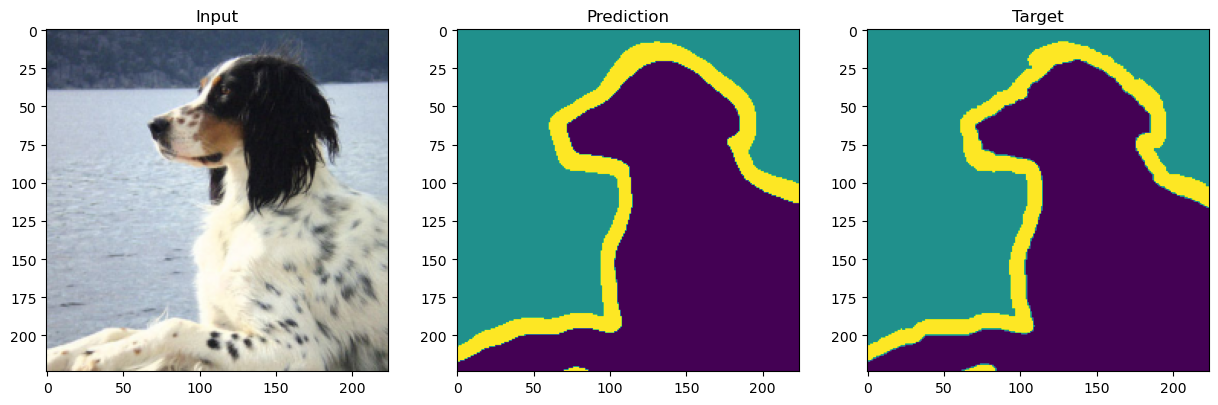

In [8]:
model.eval()

with torch.no_grad():

    a, b = next(iter(test_loader))
    a = a.to(device)
    unique, classes = torch.unique(b, return_inverse=True)
    onehot = nn.functional.one_hot(classes, 3).squeeze(dim=1).permute(0, 3, 1, 2)
    onehot = torch.argmax(onehot, dim=1)

    c = model(a[0].unsqueeze(0))
    c = torch.argmax(c, dim=1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(a[0].permute(1, 2, 0).detach().cpu().numpy())
    ax[0].set_title('Input')
    ax[1].imshow(c[0].detach().cpu().numpy())
    ax[1].set_title('Prediction')
    ax[2].imshow(onehot[0].numpy())
    ax[2].set_title('Target')